In [2]:
!pip install pyvi
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras.layers
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, GRU, Input, GlobalMaxPooling1D, LayerNormalization, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from pyvi import ViUtils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
from os import terminal_size
import regex as re
import pandas as pd

datafile = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/train_ok.csv',header=None)

data = pd.DataFrame({'label':datafile[0], 'text':datafile[1]})
data = data.dropna()
data = data.reset_index(drop=True)
print(len(data))

with open ('/content/drive/MyDrive/Colab Notebooks/Data/teencode.txt') as tcfile:
  teencodefile = tcfile.read()

teencodedata = teencodefile.split('\n')
teencode = {}
for x in range(0,len(teencodedata)):
  tmp = teencodedata[x].split('\t')
  teencode[tmp[0]] = tmp[1]

254928


In [32]:
uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"
 
def loaddicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic
dicchar = loaddicchar()

# Hàm chuyển Unicode dựng sẵn về Unicde tổ hợp (phổ biến hơn)
def convert_unicode(txt):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

bang_nguyen_am = [['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a'],
                  ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
                  ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
                  ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e'],
                  ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
                  ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i'],
                  ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o'],
                  ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
                  ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
                  ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u'],
                  ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
                  ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y']]
bang_ky_tu_dau = ['', 'f', 's', 'r', 'x', 'j']

nguyen_am_to_ids = {}

for i in range(len(bang_nguyen_am)):
    for j in range(len(bang_nguyen_am[i]) - 1):
        nguyen_am_to_ids[bang_nguyen_am[i][j]] = (i, j)

def chuan_hoa_dau_tu_tieng_viet(word):
    if not is_valid_vietnam_word(word):
        return word
    chars = list(word)
    while(len(chars)>1):
      if(chars[-1] == chars[-2]):
        del chars[-1]
      else:
        break
    dau_cau = 0
    nguyen_am_index = []
    qu_or_gi = False
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x == -1:
            continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True
        if y != 0:
            dau_cau = y
            chars[index] = bang_nguyen_am[x][0]
        if not qu_or_gi or index != 1:
            nguyen_am_index.append(index)
    if len(nguyen_am_index) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = nguyen_am_to_ids.get(chars[1])
                chars[1] = bang_nguyen_am[x][dau_cau]
            else:
                x, y = nguyen_am_to_ids.get(chars[2], (-1, -1))
                if x != -1:
                    chars[2] = bang_nguyen_am[x][dau_cau]
                else:
                    chars[1] = bang_nguyen_am[5][dau_cau] if chars[1] == 'i' else bang_nguyen_am[9][dau_cau]
            return ''.join(chars)
        return word

    for index in nguyen_am_index:
        x, y = nguyen_am_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = bang_nguyen_am[x][dau_cau]
            # for index2 in nguyen_am_index:
            #     if index2 != index:
            #         x, y = nguyen_am_to_ids[chars[index]]
            #         chars[index2] = bang_nguyen_am[x][0]
            return ''.join(chars)

    if len(nguyen_am_index) == 2:
        if nguyen_am_index[-1] == len(chars) - 1:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            chars[nguyen_am_index[0]] = bang_nguyen_am[x][dau_cau]
            # x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            # chars[nguyen_am_index[1]] = bang_nguyen_am[x][0]
        else:
            # x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            # chars[nguyen_am_index[0]] = bang_nguyen_am[x][0]
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    else:
        # x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
        # chars[nguyen_am_index[0]] = bang_nguyen_am[x][0]
        x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
        chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
        # x, y = nguyen_am_to_ids[chars[nguyen_am_index[2]]]
        # chars[nguyen_am_index[2]] = bang_nguyen_am[x][0]
    return ''.join(chars)


def is_valid_vietnam_word(word):
    chars = list(word)
    nguyen_am_index = -1
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x != -1:
            if nguyen_am_index == -1:
                nguyen_am_index = index
            else:
                if index - nguyen_am_index != 1:
                    return False
                nguyen_am_index = index
    return True


def chuan_hoa_dau_cau_tieng_viet(sentence):
    sentence = sentence.lower()
    words = sentence.split()
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        # print(cw)
        if len(cw) == 3:
            cw[1] = chuan_hoa_dau_tu_tieng_viet(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)

def remove_html(txt):
    return re.sub(r'<[^>]*>', '', txt)

def text_preprocess(document):
    # xóa html code
    document = remove_html(document)
    # chuẩn hóa unicode
    document = convert_unicode(document)
    # chuẩn hóa cách gõ dấu tiếng Việt
    document = chuan_hoa_dau_cau_tieng_viet(document)
    # đưa về lower
    document = document.lower()
    # xóa các ký tự không cần thiết
    document = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',document)
    # xóa khoảng trắng thừa
    document = re.sub(r'\s+', ' ', document).strip()
    # teencode
    listtext = document.split()
    for x in range(0,len(listtext)):
      for y in teencode:
        if(listtext[x]==y): listtext[x]=teencode[y]
    document = ' '.join(listtext)
    return document

In [33]:
rated_comment = {'1sao':1, '1 sao':1, '1*':1, '1 *':1, 'mot sao':1, 'một sao':1, 'môt sao':1,
                 '2sao':2, '2 sao':2, '2*':2, '2 *':2, 'hai sao':2,
                 '3sao':3, '3 sao':3, '3*':3, '3 *':3, 'ba sao':3,
                 '4sao':4, '4 sao':4, '4*':4, '4 *':4, 'bon sao':4, 'bốn sao':4, 'bôn sao':4,
                 '5sao':5, '5 sao':5, '5*':5, '5 *':5, 'nam sao':5, 'năm sao':5,}

def check_comment_rated(comment):
  if(comment.find('*')==-1 and comment.find('sao')==-1):
    return -1
  rating = -1
  for tmp_rate in rated_comment:
    place_find = comment.find(tmp_rate)
    if(place_find!=-1):
      if(rating == -1):
        rating = rated_comment[tmp_rate]
      elif(rating != rated_comment[tmp_rate]):
        return -1
  return rating

In [35]:
text_pre = []
label_pre = []
text = data['text'].values
label = data['label'].values

for x in range(0,len(text)):
  input_text = list(tf.keras.preprocessing.text.text_to_word_sequence(text[x]))
  input_text = ' '.join(input_text)
  #input_text_no_accent = str(ViUtils.remove_accents(input_text).decode("utf-8"))
  input_text_pre = ViTokenizer.tokenize(input_text)
  #input_text_pre_no_accent = ViTokenizer.tokenize(input_text_no_accent)
  text_pre.append(input_text_pre)
  label_pre.append(label[x])
  #text_pre.append(input_text_pre_no_accent)
  #label_pre.append(label[x])

In [36]:
size_label = {1.0:0, 2.0:0, 3.0:0, 4.0:0, 5.0:0}

for x in range(0, len(label_pre)):
  size_label[label_pre[x]] +=1

print(size_label)

{1.0: 28294, 2.0: 14730, 3.0: 27454, 4.0: 56900, 5.0: 127550}


In [37]:
label_dict={1.0:0, 2.0:1, 3.0:2, 4.0:3, 5.0:4}
label_index = [label_dict[i] for i in label_pre]
label_tf = tf.keras.utils.to_categorical(label_index, num_classes = 5, dtype = 'float32')
maxlen=128

tokenizer_data = Tokenizer(oov_token = '<OOV>', filters = '', split = ' ')
tokenizer_data.fit_on_texts(text_pre)

tokenized_data_text = tokenizer_data.texts_to_sequences(text_pre)
vec_data = pad_sequences(tokenized_data_text, padding = 'post', maxlen = maxlen)

pickle.dump(tokenized_data_text, open("tokenizer_data.pkl","wb"))

print("input data.shape: ", vec_data.shape)
data_vocab_size = len(tokenizer_data.word_index)+1
print("data vocab size: ", data_vocab_size)

X_train, X_val, y_train, y_val = train_test_split(vec_data, label_tf, test_size=0.05, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.05, random_state=42)

print("training sample: ", len(X_train))
print("validation sample: ", len(X_val))
print("test sample: ", len(X_test))

input data.shape:  (254928, 128)
data vocab size:  55172
training sample:  230071
validation sample:  12747
test sample:  12110


In [86]:
def generate_model():
  dropout_threshold = 0.2
  input_dim = data_vocab_size
  output_dim = 64
  input_length = maxlen
  initializer = tf.keras.initializers.GlorotNormal()

  input_layer = Input(shape = (input_length))
  feature = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, embeddings_initializer="GlorotNormal")(input_layer)

  cnn_feature = Conv1D(filters=32, kernel_size=3, padding= 'same', activation='relu')(feature)
  cnn_feature = MaxPooling1D()(cnn_feature)
  cnn_feature = Dropout(dropout_threshold)(cnn_feature)
  cnn_feature = Conv1D(filters=32, kernel_size=3, padding= 'same', activation='relu')(cnn_feature)
  cnn_feature = MaxPooling1D()(cnn_feature)
  cnn_feature = LayerNormalization()(cnn_feature)
  cnn_feature = Dropout(dropout_threshold)(cnn_feature)

  bi_lstm_feature = Bidirectional(LSTM(units=32, dropout = dropout_threshold, return_sequences=True, kernel_initializer=initializer), merge_mode='concat')(feature)
  bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)

  bi_lstm_feature = Bidirectional(GRU(units=32, dropout = dropout_threshold, return_sequences=True, kernel_initializer=initializer), merge_mode='concat')(bi_lstm_feature)
  bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
  bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

  combine_feature = tf.keras.layers.Concatenate()([cnn_feature, bi_lstm_feature])
  combine_feature = GlobalMaxPooling1D()(combine_feature)
  combine_feature = LayerNormalization()(combine_feature)

  classifier = Dense(90, activation='relu')(combine_feature)
  classifier = Dropout(0.2)(classifier) 
  classifier = Dense(70, activation='relu')(classifier)
  #classifier = Dropout(0.2)(classifier) 
  classifier = Dense(50, activation='relu')(classifier)
  classifier = Dropout(0.2)(classifier) 
  classifier = Dense(30, activation='relu')(classifier)
  #classifier = Dropout(0.2)(classifier) 
  classifier = Dense(5, activation='softmax')(classifier)
  #classifier = Dropout(0.2)(classifier) 

  model = tf.keras.Model(inputs = input_layer, outputs = classifier)

  return model

model = generate_model()
adam = Adam(learning_rate = 0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 embedding_25 (Embedding)       (None, 128, 64)      3531008     ['input_26[0][0]']               
                                                                                                  
 conv1d_50 (Conv1D)             (None, 128, 32)      6176        ['embedding_25[0][0]']           
                                                                                                  
 max_pooling1d_100 (MaxPooling1  (None, 64, 32)      0           ['conv1d_50[0][0]']              
 D)                                                                                        

In [ ]:
dot_img_file = 'model_visualize.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [87]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_cnn_bilstm.h5', monitor='val_loss')
history = model.fit(x = X_train, y = y_train, validation_data = (X_val, y_val), epochs = 2, batch_size = 256, callbacks=[callback_model])

Epoch 1/2
899/899 [==============================] - 35s 31ms/step - loss: 0.9500 - accuracy: 0.6101 - val_loss: 0.8378 - val_accuracy: 0.6498
Epoch 2/2
899/899 [==============================] - 26s 29ms/step - loss: 0.8252 - accuracy: 0.6584 - val_loss: 0.8250 - val_accuracy: 0.6553


In [88]:
model.load_weights('model_cnn_bilstm.h5')
model.evaluate(X_test,y_test)

379/379 [==============================] - 4s 10ms/step - loss: 0.8286 - accuracy: 0.6595


[0.828612208366394, 0.6595375537872314]

In [89]:
def preprocess_raw_input(text_input, tokenizer):
  input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(text_input))
  input_text_pre = " ".join(input_text_pre)
  input_text_pre = ViTokenizer.tokenize(input_text_pre)
  tokenized_data_text1 = tokenizer.texts_to_sequences([input_text_pre])
  vec_data = pad_sequences(tokenized_data_text1, padding = 'post', maxlen = maxlen)
  return vec_data

def inference_model(input_feature, model):
  output = model(input_feature).numpy()[0]
  result = output.argmax()
  label_dict1 = {1:0, 2:1, 3:2, 4:3, 5:4}
  label = list(label_dict.keys())
  return label[int(result)]

def prediction(raw_input, tokenizer, model):
  text_input = text_preprocess(raw_input)
  rate_comment = check_comment_rated(text_input)
  if(rate_comment != -1):
    return rate_comment
  input_model = preprocess_raw_input(text_input, tokenizer_data)
  result = inference_model(input_model, model)
  return int(result)

my_model = generate_model()
my_model = load_model('model_cnn_bilstm.h5')

with open(r'tokenizer_data.pkl',"rb") as input_file:
  my_tokenizer = pickle.load(input_file)

In [84]:
with open('/content/train.txt') as checkfile:
  checkdata = checkfile.read()

datac = checkdata.split('\n')
labelc = []
textc = []
for x in datac:
  labelc.append(int(x[0]))
  textc.append(x[2:])

print(labelc)
print(textc)

[5, 4, 5, 5, 5, 5, 5, 3, 5, 4, 5, 4, 5, 3, 5, 5, 1, 5, 5, 5, 4, 5, 3, 5, 5, 5, 4, 5, 5, 1, 5, 5, 5, 3, 5, 5, 1, 5, 4, 1, 3, 3, 5, 5, 1, 1, 4, 3, 4, 5, 5, 4, 4, 5, 5, 4, 1, 5, 4, 5, 4, 5, 4, 3, 5, 5, 5, 5, 1, 5, 4, 4, 2, 5, 5, 5, 3, 1, 2, 3, 3, 2, 4, 4, 1, 5, 4, 3, 5, 3, 5, 5, 3, 5, 5, 3, 4, 4, 4, 5, 5, 3, 3, 3, 3, 5, 5, 5, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 3, 5, 5, 1, 1, 5, 5, 4, 5, 5, 4, 5, 2, 4, 5, 1, 2, 5, 4, 5, 5, 4, 5, 3, 2, 4, 5, 5, 4, 5, 1, 4, 5, 1, 5, 5, 3, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 4, 5, 4, 1, 4, 4, 5, 5, 5, 3, 4, 4, 3, 5, 4, 4, 5, 4, 5, 2, 1, 5, 2, 5, 5, 4, 1, 5, 5, 1, 3, 5, 5, 3, 4, 5, 5, 4, 5, 5, 4, 4, 5, 5, 4, 5, 5, 3, 4, 1, 5, 5, 5, 5, 4, 5, 4, 5, 3, 3, 4, 5, 5, 5, 5, 4, 4, 5, 1, 2, 5, 4, 5, 5, 4, 5, 5, 5, 1, 4, 4, 4, 3, 5, 5, 4, 4, 4, 5, 5, 4, 5, 5, 4, 4, 5, 4, 3, 4, 4, 5, 5, 5, 3, 3, 4, 4, 4, 5, 5, 5, 3, 4, 5, 5, 4, 4, 5, 5, 5, 4, 5, 4, 4, 4, 5, 4, 5, 4, 3, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 4, 5, 3, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 

[5, 4, 5, 5, 5, 5, 5, 3, 5, 4, 5, 4, 5, 3, 5, 5, 1, 5, 5, 5, 4, 5, 3, 5, 5, 5, 4, 5, 5, 1, 5, 5, 5, 3, 5, 5, 1, 5, 4, 1, 3, 3, 5, 5, 1, 1, 4, 3, 4, 5, 5, 4, 4, 5, 5, 4, 1, 5, 4, 5, 4, 5, 4, 3, 5, 5, 5, 5, 1, 5, 4, 4, 2, 5, 5, 5, 3, 1, 2, 3, 3, 2, 4, 4, 1, 5, 4, 3, 5, 3, 5, 5, 3, 5, 5, 3, 4, 4, 4, 5, 5, 3, 3, 3, 3, 5, 5, 5, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 3, 5, 5, 1, 1, 5, 5, 4, 5, 5, 4, 5, 2, 4, 5, 1, 2, 5, 4, 5, 5, 4, 5, 3, 2, 4, 5, 5, 4, 5, 1, 4, 5, 1, 5, 5, 3, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 4, 5, 4, 1, 4, 4, 5, 5, 5, 3, 4, 4, 3, 5, 4, 4, 5, 4, 5, 2, 1, 5, 2, 5, 5, 4, 1, 5, 5, 1, 3, 5, 5, 3, 4, 5, 5, 4, 5, 5, 4, 4, 5, 5, 4, 5, 5, 3, 4, 1, 5, 5, 5, 5, 4, 5, 4, 5, 3, 3, 4, 5, 5, 5, 5, 4, 4, 5, 1, 2, 5, 4, 5, 5, 4, 5, 5, 5, 1, 4, 4, 4, 3, 5, 5, 4, 4, 4, 5, 5, 4, 5, 5, 4, 4, 5, 4, 3, 4, 4, 5, 5, 5, 3, 3, 4, 4, 4, 5, 5, 5, 3, 4, 5, 5, 4, 4, 5, 5, 5, 4, 5, 4, 4, 4, 5, 4, 5, 4, 3, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 4, 5, 3, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 

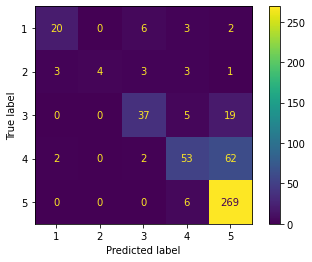

Accuracy:  0.766
Độ lệch trung bình:  0.326


In [90]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score
import random

label_check = labelc
text_check = textc

y_true = []
y_pred = []

for x in range(0,len(text_check)):
  y_true.append(label_check[x])
  y_pred.append(prediction(text_check[x], my_tokenizer, my_model))

print(y_true)
print(y_pred)

cm_pred = confusion_matrix(y_true, y_pred, labels=[1, 2, 3, 4, 5])
Matrix = ConfusionMatrixDisplay(cm_pred, display_labels=[1, 2, 3, 4, 5])

Matrix.plot()

plt.show()
print("Accuracy: ",accuracy_score(y_true,y_pred))
sum = 0
for x in range(0,len(y_true)):
  sum += abs(y_true[x] - y_pred[x])
print("Độ lệch trung bình: ", sum*1.0/len(y_true))

In [ ]:
with open('/content/pred_file.txt') as pred_file:
  text_pred_pre = pred_file.read()

text_pred_pre = text_pred_pre.split('\n')
text_pred = []
for x in text_pred_pre:
  text_pred.append(x[2:-1])

print(text_pred)

for x in range(0,len(text_pred)):
  print(str((prediction(text_pred[x], my_tokenizer, my_model))),text_pred_pre[x])


In [91]:
with open('/content/test.txt') as testfile:
  testdata = testfile.read()

datatest = testdata.split('\n')
texttest = []
for x in datatest:
  texttest.append(x[3:])

with open('result.txt','w') as wf:
  for x in texttest:
    rate = prediction(x, my_tokenizer, my_model)
    wf.write(str(rate)+' '+x+'\n')